In [166]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from src.tools import *
import numpy as np
import seaborn as sn

In [167]:
fd = open("main-logs/submission.log")
process_lines = [l for l in fd.readlines() if "Process" in l]
parsed_log = []
for l in process_lines[:-1]:
    l = l.strip().split(' ')
    try:
        item = {
            "filename": l[3],
            "gt": int(l[6].split("=")[-1]),
            "pred": int(l[7].split("=")[-1]),
            "prob": float(l[8]),
            "roi_pred": eval("".join(l[9:])),
        }
    except:
        print(l)
    parsed_log.append(item)

In [168]:
df = pd.DataFrame(parsed_log)
df["tp"] = (df["gt"] == df["pred"]).astype(int)
df["roi_n"] = df.roi_pred.apply(lambda x: len(x))
df.head()

,filename,gt,pred,prob,roi_pred,tp,roi_n
0,C12_B129_S12.tif,3,2,0.78,"[2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, ...",0,538
1,C13_B149_S11.tif,2,2,0.81,"[2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2]",1,11
2,C13_B144_S11.tif,2,2,0.52,"[2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, ...",1,17
3,C12_B127_S12.tif,2,0,0.53,"[2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, ...",0,18
4,C13_B140_S11.tif,1,1,-1.00,[],1,0


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  17 non-null     object 
 1   gt        17 non-null     int64  
 2   pred      17 non-null     int64  
 3   prob      17 non-null     float64
 4   roi_pred  17 non-null     object 
 5   tp        17 non-null     int64  
 6   roi_n     17 non-null     int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 1.1+ KB


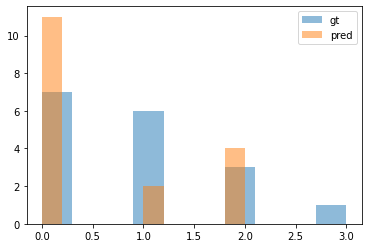

In [170]:
_ = plt.hist(df["gt"], alpha=0.5, label="gt")
_ = plt.hist(df["pred"], alpha=0.5, label="pred")
plt.legend(loc='upper right')

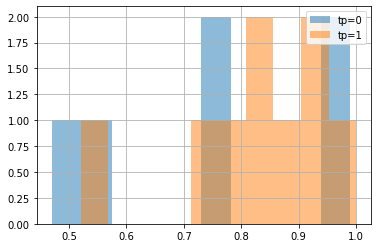

In [171]:
_ = plt.hist(df[(df["tp"] == 0) & (df["prob"]>=0)].prob, bins=10, alpha=0.5, label="tp=0")
_ = plt.hist(df[(df["tp"] == 1) & (df["prob"]>=0)].prob, bins=10, alpha=0.5, label="tp=1")
plt.legend(loc='upper right')
plt.grid()

In [172]:
df[(df["prob"]>=0) & (df["prob"] < 0.5)]

,filename,gt,pred,prob,roi_pred,tp,roi_n
16,C16_B005_S21.tif,1,2,0.47,"[0, 2, 2, 0, 3, 3, 3, 2, 2, 2, 2, 3, 0, 3, 2, ...",0,22


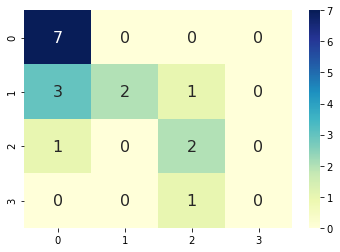

In [173]:
conf_m = confusion_matrix(df.loc[:, "gt"], df.loc[:, "pred"])
_ = sn.heatmap(conf_m, 
               annot=True, annot_kws={"size": 16}, cmap="YlGnBu")

In [174]:
print(f"gt < pred {len(df[df['gt'] < df.pred])}, gt > pred {len(df[df['gt'] > df.pred])}")

gt < pred 1, gt > pred 5


In [175]:
cm_err = ERROR_TABLE*conf_m
print(cm_err)
print(f"Metric: {1 - cm_err.sum() / len(df):.3f}")

[[0.  0.  0.  0. ]
 [0.3 0.  0.3 0. ]
 [0.7 0.  0.  0. ]
 [0.  0.  0.3 0. ]]
Metric: 0.906


In [176]:
print(f"mean values tp=1 {df[df['tp'] == 1].roi_n.mean():.1f}, tp=0 {df[df['tp'] == 0].roi_n.mean():.1f}") 
print(f"mean values for all data: {df.roi_n.mean():.1f}")

mean values tp=1 59.0, tp=0 112.7
mean values for all data: 77.9


In [177]:
# print(f"Total empty values: {len(df[df.roi_n==0])}")
# print(f"Total empty values errors: {len(df[ (df.roi_n==0) & (df.tp==0)])}")
# df_empty_roi_er = df[df.roi_n==0].copy()
# print("Error impact for empty roi list:")
# if len(df_empty_roi_er):
#     ERROR_TABLE*confusion_matrix(df_empty_roi_er.loc[:, "gt"], df_empty_roi_er.loc[:, "pred"])

In [190]:
df_test_prob = pd.read_csv("test_roi_probs.csv")
print(f"Test empty roi {len(df_test_prob[df_test_prob.t_i == 0])}")
test_targets = df_test_prob.set_index("filename").groupby("filename")["label"].head(1)
df_test_prob.head()

Test empty roi 1


,filename,x1,y1,x2,y2,prob0,prob1,prob2,prob3,t_i,t_w,t_h,t_r,t_g,t_b,label
0,C12_B129_S12.tif,98720,19736,100024,21040,0.001963,0.008073,0.986454,0.003509,1,32,25,221.999145,216.268482,226.030069,3
1,C12_B129_S12.tif,100024,19736,101328,21040,0.001626,0.001354,0.996285,0.000734,1,32,25,221.999145,216.268482,226.030069,3
2,C12_B129_S12.tif,81768,21040,83072,22344,0.005632,0.014806,0.972129,0.007433,1,32,25,221.999145,216.268482,226.030069,3
3,C12_B129_S12.tif,83072,21040,84376,22344,0.000408,0.007023,0.988262,0.004307,1,32,25,221.999145,216.268482,226.030069,3
4,C12_B129_S12.tif,98720,21040,100024,22344,0.924829,0.002100,0.072927,0.000144,1,32,25,221.999145,216.268482,226.030069,3


In [191]:
df_train_prob = pd.read_csv("train_roi_probs.csv")
print(f"Train empty roi {len(df_train_prob[df_train_prob.t_i == 0])}")
train_targets = df_train_prob.set_index("filename").groupby("filename")["label"].head(1)
df_train_prob.head(10)

Train empty roi 8


,filename,x1,y1,x2,y2,prob0,prob1,prob2,prob3,t_i,t_w,t_h,t_r,t_g,t_b,label
0,C06_B108_S21.tif,63392,23552,64712,24872,0.952884,0.021026,0.016521,0.009569,1,20,18,213.571823,181.57276,195.100044,3
1,C06_B108_S21.tif,64712,23552,66032,24872,0.109219,0.005739,0.884793,0.000249,1,20,18,213.571823,181.57276,195.100044,3
2,C06_B108_S21.tif,64712,24872,66032,26192,0.053665,0.002884,0.943038,0.000413,1,20,18,213.571823,181.57276,195.100044,3
3,C06_B108_S21.tif,62072,26192,63392,27512,0.340499,0.010350,0.649004,0.000148,1,20,18,213.571823,181.57276,195.100044,3
4,C06_B108_S21.tif,63392,26192,64712,27512,0.006896,0.057076,0.343131,0.592897,1,20,18,213.571823,181.57276,195.100044,3
5,C06_B108_S21.tif,64712,26192,66032,27512,0.009449,0.001892,0.897419,0.091241,1,20,18,213.571823,181.57276,195.100044,3
6,C06_B108_S21.tif,67352,26192,68672,27512,0.025664,0.006455,0.083429,0.884452,1,20,18,213.571823,181.57276,195.100044,3
7,C06_B108_S21.tif,68672,26192,69992,27512,0.000287,0.000083,0.998146,0.001484,1,20,18,213.571823,181.57276,195.100044,3
8,C06_B108_S21.tif,69992,26192,71312,27512,0.000059,0.000006,0.999934,0.000001,1,20,18,213.571823,181.57276,195.100044,3
9,C06_B108_S21.tif,62072,27512,63392,28832,0.023124,0.010045,0.012290,0.954542,1,20,18,213.571823,181.57276,195.100044,3


[[ 0.   4.  11.2  1. ]
 [ 0.2  0.   0.3  0. ]
 [ 0.   1.2  0.   6.3]
 [ 7.   8.4  3.   0. ]]
Metric: 0.790


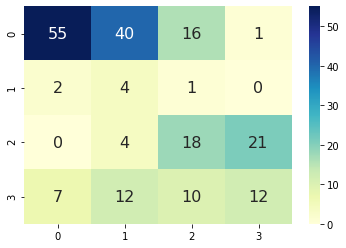

In [192]:
naive_clf_pred = df_test_prob.groupby("filename")[["prob0", "prob1", "prob2", "prob3"]].mean().values.argmax(axis=1)
test_label = df_test_prob.groupby("filename")["label"].max()

conf_m = confusion_matrix(naive_clf_pred, test_label)
_ = sn.heatmap(conf_m, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
cm_err = ERROR_TABLE*conf_m
print(cm_err)
print(f"Metric: {1 - cm_err.sum() / len(naive_clf_pred):.3f}")

TEST:

[[0.  1.4 4.2 0. ]
 [2.7 0.  2.7 0. ]
 [2.8 3.6 0.  1.8]
 [0.  0.7 1.5 0. ]]
Metric: 0.895


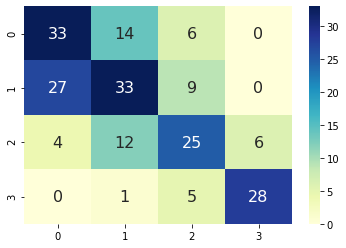

In [193]:
import pickle
from src.rf_clf import predict_random_forest, build_df
clf = pickle.load(open("models/rf-clf.pkl", 'rb'))

def eval_clf(clf, df, targets):
    clf_preds = predict_random_forest(clf, df)
    clf_preds = clf_preds.set_index("filename")
    conf_m = confusion_matrix(clf_preds.iloc[:, 0:].values.argmax(axis=1), targets[clf_preds.index])
    _ = sn.heatmap(conf_m, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
    cm_err = ERROR_TABLE*conf_m
    print("TEST:")
    print()
    print(cm_err)
    print(f"Metric: {1 - cm_err.sum() / len(targets):.3f}")
    return clf_preds

clf_test = eval_clf(clf, df_test_prob, test_targets)

TEST:

[[ 0.   1.6  4.2  1. ]
 [ 1.4  0.   5.1  3.5]
 [10.5  4.5  0.   0.6]
 [ 1.   1.4  3.3  0. ]]
Metric: 0.953


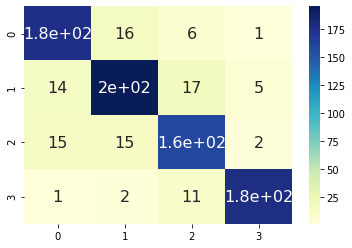

In [194]:
_ = eval_clf(clf, df_train_prob, train_targets)

In [152]:
df_rf = build_df(df_test_prob)
cls_prob = clf.predict_proba(df_rf.iloc[:, 0:-1])
df_rf["clf_cls"] = cls_prob.argmax(axis=1)
df_rf["clf_prob"] = cls_prob[range(len(cls_prob)), df_rf["clf_cls"].values]
df_rf["clf_prob0"] = cls_prob[:, 0]
df_rf["clf_prob1"] = cls_prob[:, 1]
df_rf["clf_prob2"] = cls_prob[:, 2]
df_rf["clf_prob3"] = cls_prob[:, 3]
df_rf.head()

,pred_class0,pred_class1,pred_class2,pred_class3,prob0_mean,prob0_max,prob0_min,prob0_var,prob0_std,prob1_mean,...,t_b,t_n,pred_n,label,clf_cls,clf_prob,clf_prob0,clf_prob1,clf_prob2,clf_prob3
filename,,,,,,,,,,,,,,,,,,,,,
C01_B003_S01.tif,11,23,0,5,0.278643,0.921931,0.000001,0.090043,0.300072,0.588667,...,187.474269,2,39,1,1,0.596884,0.241597,0.596884,0.110938,0.050581
C01_B044_S01.tif,74,100,3,16,0.394720,0.999870,0.000045,0.143519,0.378840,0.511709,...,189.879705,6,193,1,1,0.611650,0.126356,0.611650,0.189452,0.072543
C01_B050_S01.tif,11,26,4,0,0.293308,0.998223,0.000418,0.128534,0.358516,0.609968,...,173.161957,3,41,1,1,0.721272,0.080890,0.721272,0.171682,0.026156
C01_B054_S01.tif,2,20,1,1,0.119877,0.903479,0.000249,0.044979,0.212082,0.750435,...,179.664880,3,24,1,1,0.804453,0.081494,0.804453,0.082170,0.031884
C01_B109_S01.tif,51,19,2,0,0.660562,0.996757,0.000166,0.117027,0.342092,0.309205,...,182.943976,3,72,1,1,0.637908,0.286648,0.637908,0.059757,0.015687


In [153]:
df_rf[(df_rf["clf_cls"] != df_rf["label"]) & (df_rf["clf_prob"]>0.6)]

,pred_class0,pred_class1,pred_class2,pred_class3,prob0_mean,prob0_max,prob0_min,prob0_var,prob0_std,prob1_mean,...,t_b,t_n,pred_n,label,clf_cls,clf_prob,clf_prob0,clf_prob1,clf_prob2,clf_prob3
filename,,,,,,,,,,,,,,,,,,,,,
C01_B212_S01.tif,13,19,0,0,0.457051,0.965781,9.223466e-03,0.094907,0.308069,0.511051,...,172.513573,4,32,0,1,0.698177,0.229987,0.698177,0.051475,0.020361
C01_B242_S01.tif,9,2,0,4,0.573361,0.998910,3.372057e-06,0.201914,0.449349,0.164575,...,170.019924,3,15,0,1,0.600803,0.263675,0.600803,0.089701,0.045822
C01_B267_S01.tif,0,2,17,5,0.007109,0.107305,6.441646e-10,0.000518,0.022767,0.083934,...,176.687170,5,24,3,2,0.789511,0.004968,0.036254,0.789511,0.169267
C02_B054_S21.tif,13,18,0,0,0.419954,0.999915,5.298167e-04,0.178297,0.422252,0.571943,...,189.531832,3,31,2,1,0.638121,0.222854,0.638121,0.133487,0.005538
C02_B086_S21.tif,0,0,14,1,0.009614,0.129722,3.639676e-06,0.001108,0.033279,0.008505,...,189.185046,3,15,1,2,0.932022,0.023370,0.027412,0.932022,0.017197
C02_B143_S21.tif,16,50,0,2,0.256644,0.998956,3.097354e-05,0.110117,0.331838,0.701619,...,193.722177,6,68,2,1,0.746258,0.155917,0.746258,0.085562,0.012263
C02_B292_S21.tif,22,4,0,0,0.848957,0.999947,8.903313e-02,0.080243,0.283273,0.136276,...,202.255167,9,26,1,0,0.816878,0.816878,0.165598,0.016523,0.001000
C05_B025_S11.tif,33,46,5,2,0.431292,0.996867,6.060756e-04,0.115326,0.339596,0.490905,...,236.049019,12,86,0,1,0.652695,0.222038,0.652695,0.109682,0.015586
C06_B026_S21.tif,3,8,93,14,0.033537,0.997447,1.118558e-09,0.018373,0.135547,0.073158,...,188.104491,4,118,3,2,0.602006,0.038267,0.055943,0.602006,0.303784


(203,)

In [127]:
df_rf["clf_cls"].values

array([1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 0, 1, 0, 2, 1, 0, 0, 2, 2, 2,
       0, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0,
       0, 2, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 2, 0, 3, 0, 2, 1, 2, 1, 3,
       0, 2, 1, 1, 0, 2, 0, 1, 1, 1, 2, 3, 3, 0, 1, 1, 1, 2, 0, 3, 3, 1,
       2, 0, 3, 3, 3, 0, 3, 0, 0, 3, 1, 1, 1, 3, 1, 1, 1, 1, 2, 0, 2, 1,
       0, 0, 2, 0, 1, 2, 2, 3, 2, 1, 1, 1, 1, 0, 2, 2, 1, 3, 1, 3, 3, 2,
       3, 2, 3, 3, 2, 3, 0, 2, 3, 3, 1, 2, 1, 0, 3, 3, 1, 3, 1, 0, 1, 2,
       1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0,
       2, 1, 1, 1, 0, 0, 1, 2, 0, 0, 2, 0, 2, 0, 1, 0, 1, 1, 3, 0, 0, 0,
       1, 0, 1, 1, 3])

In [217]:
submission_df = pd.read_csv("submission/submission.csv")
submission_df.head()

,filename,0,1,2,3
0,C12_B129_S12.tif,0,0,0,1
1,C13_B149_S11.tif,0,0,1,0
2,C13_B144_S11.tif,0,0,1,0
3,C12_B127_S12.tif,0,0,1,0
4,C13_B140_S11.tif,0,1,0,0


In [218]:
submission_fmt = pd.read_csv("inference-data-2/submission_format.csv")
assert len(submission_fmt) == len(submission_df)
test_labels = pd.read_csv("inference-data-2/test_labels.csv")
submission_fmt.head()


,filename,0,1,2,3
0,C12_B129_S12.tif,0,0,0,0
1,C13_B149_S11.tif,0,0,0,0
2,C13_B144_S11.tif,0,0,0,0
3,C12_B127_S12.tif,0,0,0,0
4,C13_B140_S11.tif,0,0,0,0


In [219]:
submission_pred = submission_df.loc[:, "0":"3"].values.argmax(axis=1)
submission_gt = test_labels.loc[:, "0":"3"].values.argmax(axis=1)
1 - ERROR_TABLE[submission_pred, submission_gt].sum() / len(submission_gt)

0.9389162561576354

In [216]:
df = pd.read_csv("pseudo-clf.csv")
df.groupby("pseudo_class").prob.max()

pseudo_class
-1    0.999869
 0    0.999882
 1    0.999868
 2    0.999827
 3    0.999833
Name: prob, dtype: float64